In [77]:
import os
import time 

import numpy as np
import pandas as pd
import lightgbm as lgb

from lightgbm import LGBMModel, LGBMClassifier
from contextlib import contextmanager
from sklearn.metrics import matthews_corrcoef, roc_auc_score
from sklearn.cross_validation import cross_val_score, StratifiedKFold

important_indices = np.array([0,23,33,34,36,51,76,121,123,130,139,402,805,831
,883,939,1018,1019,1029,1034,1042,1056,1156,1161,1164,1165,1166,1167
,1168,1169,1171,1173,1177,1178,1180,1182,1183,1186,1189,1190,1191,1193
,1194,1196,1201,1203,1204,1206,1208,1209,1215,1219,1221,1222,1225,1226
,1231,1233,1234,1238,1239,1244,1246,1247,1249,1250,1252,1255,1258,1263
,1267,1270,1272,1274,1278,1282,1283,1285,1291,1298,1308,1311,1313,1316
,1410,1411,1475,1476,1477,1481,1482,1483,1487,1488,1490,1493,1494,1495
,1497,1504,1512,1515,1516,1520,1523,1526,1527,1539,1540,1542,1543,1549
,1550,1552,1562,1582,1592,1594,1597,1818,1827,1832,1833,1840,1843,1844
,1846,1848,1849,1852,1858,1879,1880,1881,1882,1883,1884,1885,1886,1887
,1888,1889,1890,1891,1894,1897,1898,1900,1911,1914,1921,1925,1927,1932
,1934,1936,1937,1938,1942,1944,1946,1947,1948,1958,1959,1960,1961,1962
,1968,1970,1971,1974,1975,1983,1984,1985,1988,1992,1993,1994,1995,1997
,1999,2004,2006,2007,2010,2020,2026,2027,2028,2040,2041,2047,2048,2062
,2064,2067,2093])

features = ['same_to_next_or_prev.f','same_to_next_or_prev_t.f', 'timediff.f']

@contextmanager
def timer(name):
    t0 = time.time()
    yield
    print('[{}] done in {} s'.format(time.time(), time.time() - t0))

def add_features(df, features):
    for f in features:
        df_feat = pd.read_feather(f)
        df = pd.merge(df, df_feat, on='Id', how='left')
    return df

def make_data(df_date, df_numeric, important_indices, features):
    N_DATE_FEATURES = 1156

    x = pd.concat([
        pd.read_csv(df_date, index_col=0, dtype=np.float32,
                    usecols=np.concatenate([[0], important_indices[important_indices < N_DATE_FEATURES] + 1])),
        pd.read_csv(df_numeric, index_col=0, dtype=np.float32,
                    usecols=np.concatenate([[0], important_indices[important_indices >= N_DATE_FEATURES] + 1 - N_DATE_FEATURES]))
    ], axis=1)  
    x.reset_index(inplace=True)
    x = add_features(x, features)
    x.set_index('Id', inplace=True)
    
    if 'index' in x:
        print('remove index')
        x.drop('index', axis=1, inplace=True)
    return x

In [78]:
with timer("load data"):
    x_train = make_data("../input/train_date.csv", "../input/train_numeric.csv", important_indices, features)
    x_test  = make_data("../input/test_date.csv", "../input/test_numeric.csv", important_indices, features)
    y_train = pd.read_csv("../input/train_numeric.csv", index_col=0, dtype=np.float32, usecols=[0,969]).values.ravel()

C:\Users\noumi\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\numpy\lib\arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


remove index
remove index
[1531323177.194281] done in 138.35566115379333 s


In [79]:
lgbparams = {
    'max_depth' : 6,
    'num_leaves' : 48,
    'learning_rate' : 0.03,
    'n_estimators' : 500,
    'min_child_samples' : 100,
    'colsample_bytree' : 0.5,
    'objective' : 'binary',
    'reg_alpha' : 0.1,
    'reg_lambda' : 1.0,
    'seed' : 0
}

with timer("cross validation"):
    n_folds=5
    
    cv = StratifiedKFold(y_train, n_folds)
    clfs = []
    preds_oof  = np.ones(y_train.shape[0])
    preds_test = np.empty((n_folds, x_test.shape[0]))

    for i, (train, valid) in enumerate(cv):
        clf = LGBMClassifier(**lgbparams)
        clf.fit(x_train.iloc[train], 
                y_train[train], 
                eval_set=[(x_train.iloc[valid], y_train[valid])], 
                early_stopping_rounds=50, 
                verbose=50)
        preds_oof[valid] = clf.predict_proba(x_train.iloc[valid])[:,1]
        preds_test[i, :] = clf.predict_proba(x_test)[:,1]
        
        print("fold {}, ROC AUC: {:.3f}".format(i, roc_auc_score(y_train[valid], preds_oof[valid])))
        clfs.append(clf)
    print(roc_auc_score(y_train, preds_oof))


Training until validation scores don't improve for 50 rounds.
[50]	valid_0's binary_logloss: 0.131376
[100]	valid_0's binary_logloss: 0.0447437
[150]	valid_0's binary_logloss: 0.0283912
[200]	valid_0's binary_logloss: 0.0251716
[250]	valid_0's binary_logloss: 0.024562
[300]	valid_0's binary_logloss: 0.0244078
[350]	valid_0's binary_logloss: 0.0243669
[400]	valid_0's binary_logloss: 0.0243522
[450]	valid_0's binary_logloss: 0.0243354
[500]	valid_0's binary_logloss: 0.0243265
Did not meet early stopping. Best iteration is:
[499]	valid_0's binary_logloss: 0.0243263
fold 0, ROC AUC: 0.880
Training until validation scores don't improve for 50 rounds.
[50]	valid_0's binary_logloss: 0.131567
[100]	valid_0's binary_logloss: 0.0449515
[150]	valid_0's binary_logloss: 0.0285198
[200]	valid_0's binary_logloss: 0.025083
[250]	valid_0's binary_logloss: 0.0244258
[300]	valid_0's binary_logloss: 0.0242286
[350]	valid_0's binary_logloss: 0.0241848
[400]	valid_0's binary_logloss: 0.0241683
[450]	valid_0

0.39122061755776705
[1531324247.0506814] done in 43.371464252471924 s


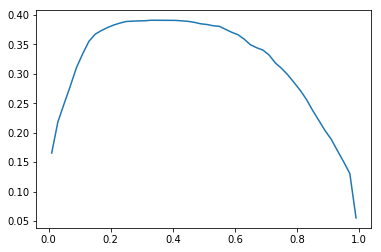

In [82]:
import matplotlib.pyplot as plt
%matplotlib inline

with timer("mcc maximization"):
    # pick the best threshold out-of-fold
    thresholds = np.linspace(0.01, 0.99, 50)
    mcc = np.array([matthews_corrcoef(y_train, preds_oof>thr) for thr in thresholds])
    plt.plot(thresholds, mcc)
    best_threshold = thresholds[mcc.argmax()]
    print(mcc.max())

In [83]:
with timer("submit prediction"):
    preds = preds_test.mean(axis=0)
    sub = pd.read_csv('../input/sample_submission.csv')
    sub['Response'] = preds > best_threshold
    sub['Response'] = sub['Response'].astype(np.int32)
    sub.to_csv('../output/lgb_private0.41291.csv',index=False)


[1531324250.180313] done in 3.0628104209899902 s


In [84]:
# feature ranking
fi = list(zip(clf.feature_importances_, x_train.columns.tolist()))
fi.sort(key=lambda tup: -tup[0]) 
fi[:40]

[(1086, 'mean_diff_m1'),
 (330, 'L3_S33_D3856'),
 (301, 'L3_S33_F3865'),
 (301, 'mean_num'),
 (286, 'L3_S29_D3316'),
 (284, 'L3_S34_D3875'),
 (267, 'L3_S33_F3857'),
 (260, 'L3_S30_F3704'),
 (260, 'prev_failed_t'),
 (245, 'L3_S33_F3859'),
 (223, 'same_to_prev'),
 (221, 'L3_S29_D3474'),
 (215, 'mean_diff_p1'),
 (206, 'L3_S29_F3351'),
 (189, 'L3_S30_F3774'),
 (188, 'L3_S30_F3759'),
 (185, 'L3_S30_F3809'),
 (183, 'L3_S32_D3852'),
 (181, 'S2_td'),
 (165, 'L3_S29_F3348'),
 (165, 'S3_td'),
 (163, 'L3_S30_F3754'),
 (161, 'L3_S30_F3749'),
 (156, 'L3_S30_F3574'),
 (153, 'L3_S30_F3804'),
 (152, 'L3_S30_F3829'),
 (151, 'L3_S30_F3554'),
 (150, 'L3_S29_F3479'),
 (147, 'prev_failed'),
 (143, 'L3_S29_F3342'),
 (140, 'same_to_next'),
 (138, 'L3_S29_F3339'),
 (136, 'L1_S24_F1723'),
 (134, 'L3_S29_F3373'),
 (130, 'L3_S29_F3345'),
 (130, 'L3_S30_F3494'),
 (128, 'L0_S0_F20'),
 (128, 'L3_S36_F3920'),
 (127, 'L3_S29_F3327'),
 (124, 'L1_S24_F1846')]

In [72]:
train_index = pd.read_csv('../input/train_numeric.csv', index_col=0, dtype=np.int32, usecols=[0]).reset_index()

def to_csv(df, train_ids, filename):
    df_train = df[df['Id'].isin(train_ids)]
    df_test = df[~df['Id'].isin(train_ids)]
    
    df_train.to_csv('train_'+filename+'.csv', index=False)
    df_test.to_csv('test_'+filename+'.csv', index=False)
    
f = pd.read_feather(features[0])    
f.rename(columns={'mean_diff_p1':'diff2next', 'mean_diff_m1':'diff2prev'}, inplace=True)

to_csv(f[['Id','diff2prev','diff2next']], train_index['Id'], 'diff2adj')
to_csv(f[['Id','mean_num']], train_index['Id'], 'mean_num')
to_csv(f[['Id','prev_failed','next_failed']], train_index['Id'], 'adj_failed')

f2 = pd.read_feather(features[1])
to_csv(f2[['Id','prev_failed_t','next_failed_t']], train_index['Id'], 'adj_failed_t')

f3 = pd.read_feather(features[2])
f3.rename(columns={'S1_td':'time_diff_S1',
                  'S2_td':'time_diff_S2',
                  'S3_td':'time_diff_S3',
                  'S4_td':'time_diff_S4',
                  'S5_td':'time_diff_S5',
                  'S24_td':'time_diff_S24',
                  'S25_td':'time_diff_S25'}, inplace=True)
to_csv(f3, train_index['Id'], 'time_diff')
